In [1]:
import pandas as pd
import numpy as np
import time 
import datetime 
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

<font color='blue'>
# Read and prepare data

In [2]:
abbreviations = {
    6:'desktop',
    7:'mobile',
    'f':'women',
    'm':'men'
}

In [3]:
# time_stamp when A/B test begins
TEST_TIME = datetime.datetime.strptime('24.03.2017 16:00',"%d.%m.%Y %H:%M")

# read data
data = pd.read_csv('./data/Test_4.csv', sep=';', parse_dates=['time_stamp','reg_date'])

# data preparation
data = data.sort_values(['time_stamp'], ignore_index=True)
data['test_user'] = data['sender_id']%2
data['date'] = data['time_stamp'].apply(lambda x: x.date())
data['time_stamp_hour'] = data['time_stamp'].apply(lambda x: x.replace(second=0, minute=0, hour=x.hour))
data.loc[data['gender']==' ','gender'] = 'undef'

# lets drop data of the day 2017-03-27 (for plot purpose) as we have only 1 observation of that day
data = data[data['date']!=datetime.date(2017,3,27)]

In [4]:
data.head()

,sender_id,platform_id,time_stamp,gender,reg_date,test_user,date,time_stamp_hour
0,3216638736,6,2017-03-13,m,2017-12-03,0,2017-03-13,2017-03-13
1,3208345122,7,2017-03-13,m,2017-01-30,0,2017-03-13,2017-03-13
2,3216638736,6,2017-03-13,m,2017-12-03,0,2017-03-13,2017-03-13
3,3216638736,6,2017-03-13,m,2017-12-03,0,2017-03-13,2017-03-13
4,3206963084,6,2017-03-13,m,2017-01-23,0,2017-03-13,2017-03-13


<font color='blue'>
- There are 30% of data where time_stamp < reg_date. 
- This means that unregistered users also can send likes.

In [5]:
k = data[data['time_stamp'] < data['reg_date']].shape[0] / data.shape[0] * 100
print(f'percent of data where unregistered users sent likes: {k:.0f} %')

# define observed time_stamp interval
time_stamp_min = data['time_stamp'].min()
time_stamp_max = data['time_stamp'].max()

percent of data where unregistered users sent likes: 30 %


# exploratory analysis

<font color='blue'>
Let's name :
- base variant as A
- test variant as B

In [6]:
# check if split on train and test is equal
print(data[['sender_id','test_user']].drop_duplicates()['test_user'].value_counts())

0    13295
1    13026
Name: test_user, dtype: int64


<font color='blue'>

# Plot graphs

- red line indicates the start of AB-test

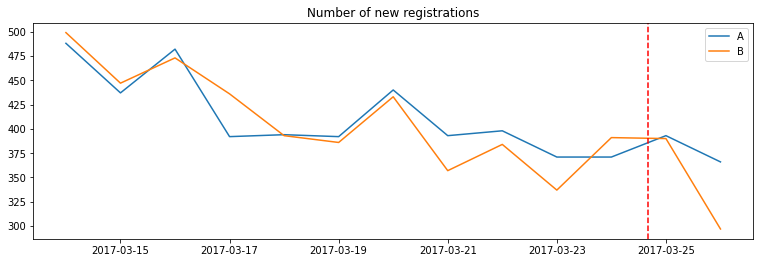

In [7]:
# number of new registrations per day
reg_dates = data.drop_duplicates(['sender_id'])[['sender_id','reg_date','test_user']]
reg_dates = reg_dates[(reg_dates['reg_date'] > time_stamp_min) & (reg_dates['reg_date'] < time_stamp_max)]
new_per_day = reg_dates.groupby(['reg_date','test_user'])['sender_id'].count()

fig = plt.figure(figsize=(10,3))
axes = fig.add_axes([0,0,1,1])
axes.plot(new_per_day.loc[:,0].index, new_per_day.loc[:,0].values, label='A')
axes.plot(new_per_day.loc[:,1].index, new_per_day.loc[:,1].values, label='B')
axes.axvline(TEST_TIME, color='r', ls='--')
axes.legend()
axes.set_title('Number of new registrations')
plt.show()

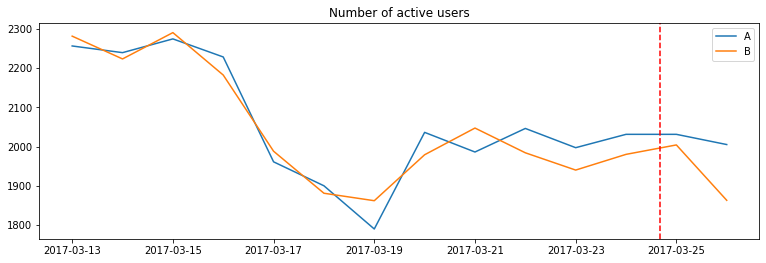

In [8]:
# number of active users per day
active_per_day = data.groupby(['date','test_user'])['sender_id'].nunique()

fig = plt.figure(figsize=(10,3))
axes = fig.add_axes([0,0,1,1]) 
axes.plot(active_per_day.loc[:,0].index, active_per_day.loc[:,0].values, label='A')
axes.plot(active_per_day.loc[:,1].index, active_per_day.loc[:,1].values, label='B')
axes.axvline(TEST_TIME, color='r', ls='--')
axes.legend()
axes.set_title('Number of active users')
plt.show()

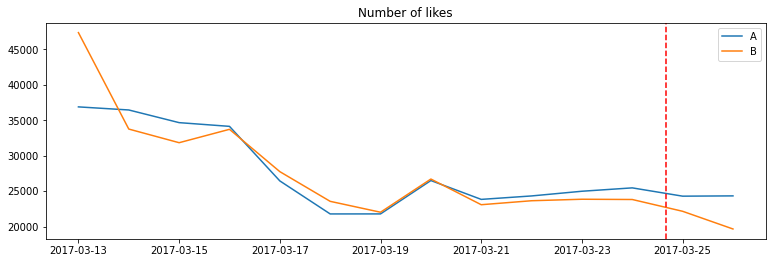

In [9]:
# total number of likes sent per day
likes_per_day = data.groupby(['date','test_user'])['sender_id'].count()

fig = plt.figure(figsize=(10,3))
axes = fig.add_axes([0,0,1,1])
axes.plot(likes_per_day.loc[:,0].index, likes_per_day.loc[:,0].values, label='A')
axes.plot(likes_per_day.loc[:,1].index, likes_per_day.loc[:,1].values, label='B')
axes.axvline(TEST_TIME, color='r', ls='--')
axes.legend()
axes.set_title('Number of likes')
plt.show()

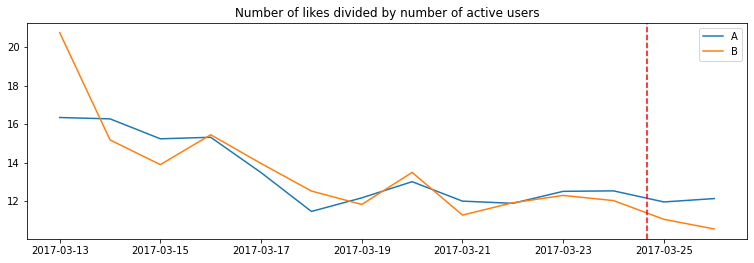

In [10]:
# total number of likes sent per day divided by the number of active users
likes_per_userday = likes_per_day/active_per_day

fig = plt.figure(figsize=(10,3))
axes = fig.add_axes([0,0,1,1]) 
axes.plot(likes_per_userday.loc[:,0].index, likes_per_userday.loc[:,0].values, label='A')
axes.plot(likes_per_userday.loc[:,1].index, likes_per_userday.loc[:,1].values, label='B')
axes.axvline(TEST_TIME, color='r', ls='--')
axes.legend()
axes.set_title('Number of likes divided by number of active users')
plt.show()

<font color='blue'>
Plot distribution in sub-groups

- Divide users into 4 subcategories by platform_id and gender 
- Check number of likes after AB-test start

- for the subcategory 'men on mobile' there is a decreasing number of likes at test B 
- for other subcategories number of likes is pretty the same (according to graphs)

In [11]:
test_data = data[(data['time_stamp'] > TEST_TIME) & (data['gender'] != 'undef')]

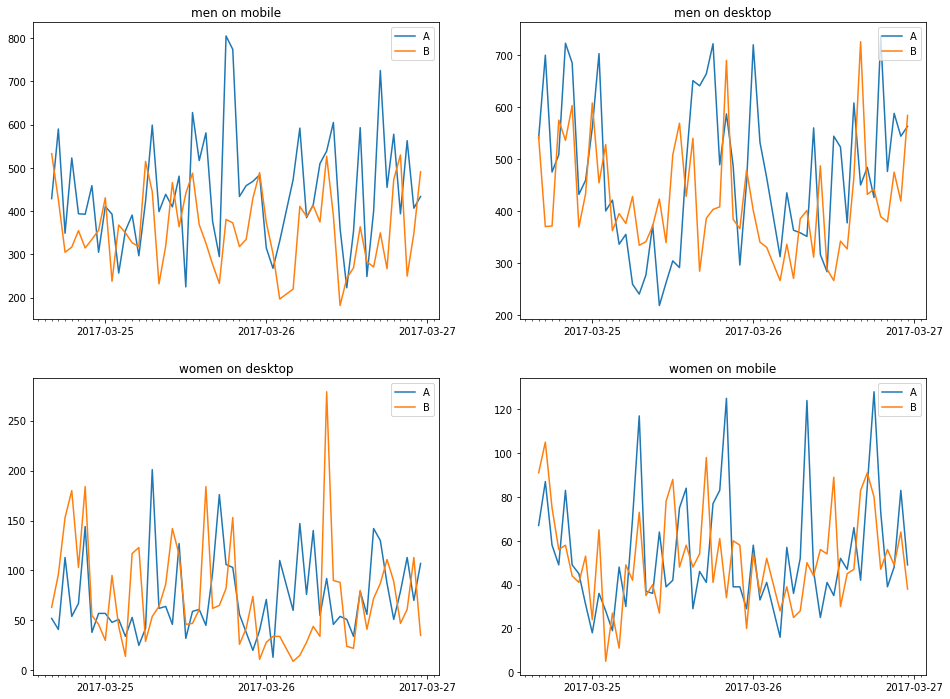

In [12]:
groups = test_data.groupby(['time_stamp_hour','gender','platform_id','test_user'])['time_stamp'].count()
categories = test_data[['gender','platform_id']].drop_duplicates().values

days = mdates.DayLocator()
hours = mdates.HourLocator()

fig, axes = plt.subplots(2,2, figsize=(16,12))
axes = axes.ravel() 

for i, ax in enumerate(axes):
    cat = categories[i]
    
    subdata_0 = groups.loc[:, cat[0], cat[1], 0]
    subdata_1 = groups.loc[:, cat[0], cat[1], 1]
    
    ax.plot(subdata_0.index, subdata_0.values, label='A')
    ax.plot(subdata_1.index, subdata_1.values, label='B')
    
    ax.xaxis.set_major_locator(days)
    ax.xaxis.set_minor_locator(hours)

    ax.legend(loc='upper right')
    ax.set_title('{} on {}'.format(abbreviations[cat[0]], abbreviations[cat[1]]))

plt.show()

<font color='blue'>
- Check number of likes in groups A and B after AB-test start
- (number of likes in group B is less than in group A)

In [13]:
likes_groups = test_data.groupby(['test_user'])['time_stamp'].count().\
    reset_index(name='count')
print(likes_groups)

   test_user  count
0          0  57599
1          1  49926


<font color='blue'>
- Check number of likes in sub-groups after AB-test start

In [14]:
likes_subgroups  = test_data.groupby(['gender','platform_id','test_user'])['time_stamp'].count().\
    reset_index(name='count')
print(likes_subgroups)

  gender  platform_id  test_user  count
0      f            6          0   4073
1      f            6          1   4112
2      f            7          0   2996
3      f            7          1   2852
4      m            6          0  26019
5      m            6          1  23265
6      m            7          0  24511
7      m            7          1  19697


<font color='blue'>

# Student's t-test

- perform t-test for the number of likes in groups A and B
- we test the hypothesis that samples have identical average values
- as p-value (p=0.0003) is small so we reject the null hypothesis of equal average number of likes in groups A and B
- so as avg values are not the same and total number of likes in group B is less than in group A, then **test variant should be rejected**

In [15]:
test_likes = test_data.groupby(['time_stamp_hour','test_user'])['time_stamp'].count()

test_likes_0 = test_likes.loc[:,0]
test_likes_1 = test_likes.loc[:,1]


t, p = stats.ttest_ind(test_likes_0.values, test_likes_1.values)
print(f"t={t:.4f}, p={p:.4f}")

t=3.7616, p=0.0003


<font color='blue'>
- Let's also calculate t-test statistics for subcategories 
- so we reject the null hypothesis of equal averages for 'men on mobile' and 'men on desktop' groups
(which pretty aligns with the graphs shown above)

In [16]:
ttest_df = pd.DataFrame()

groups = test_data.groupby(['time_stamp_hour','gender','platform_id','test_user'])['time_stamp'].count()
categories = test_data[['gender','platform_id']].drop_duplicates().values

for cat in categories:    
    subdata_0 = groups.loc[:, cat[0], cat[1], 0]
    subdata_1 = groups.loc[:, cat[0], cat[1], 1]
    
    # test hypothesis that samples have identical average values
    t, p = stats.ttest_ind(subdata_0.values, subdata_1.values)
    group = '{} on {}'.format(abbreviations[cat[0]], abbreviations[cat[1]])
    ttest_df = ttest_df.append({'group':group, 't':t, 'p':p}, ignore_index=True)

print(ttest_df)

              group         p         t
0     men on mobile  0.000071  4.131568
1    men on desktop  0.039353  2.085791
2  women on desktop  0.937395 -0.078728
3   women on mobile  0.576458  0.560266


<font color='blue'>

# Confidence interval

Build confidence interval (95% confidence) for the rolling mean of the 'number of likes per hour' in group A.

Notice that the observed mean number of likes in group B is inside that interval till the beginning of AB-test, and goes down afterward, so **test variant should be rejected**.


In [17]:
likes = data.groupby(['time_stamp_hour','test_user'])['time_stamp'].count()

likes_0 = likes.loc[:,0]
likes_1 = likes.loc[:,1]

window = 24
mean_0 = likes_0.rolling(window).mean()
std_0 = likes_0.rolling(window).std()
sem_0 = std_0 / np.sqrt(window)

k = 1.96
lower = mean_0 - k * sem_0
upper = mean_0 + k * sem_0

mean_1 = likes_1.rolling(window).mean()

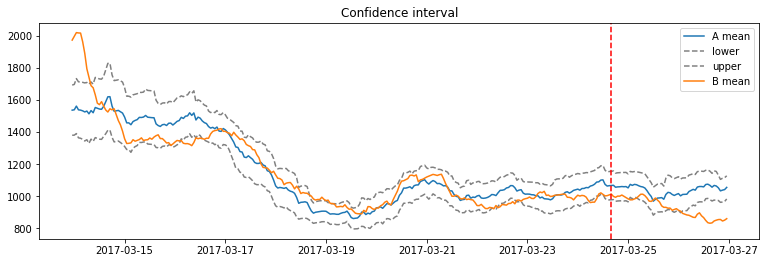

In [18]:
fig = plt.figure(figsize=(10,3))
axes = fig.add_axes([0,0,1,1]) 

axes.plot(mean_0.index, mean_0.values, label='A mean')
axes.plot(lower.index, lower.values, ls='--', color='gray', label='lower')
axes.plot(upper.index, upper.values, ls='--', color='gray', label='upper')
axes.plot(mean_1.index, mean_1.values, label='B mean')
axes.axvline(TEST_TIME, color='r', ls='--')

axes.legend()
axes.set_title('Confidence interval')
plt.show()

<font color='blue'>
# Test variant should be rejected .